# 8. Start the project <a id='8.'></a>

This section contains below all the source code including your implementation and the tasks and question that need to be filled. 

<div class=" alert alert-warning">
    <h3><b>Initialize the code</b> </h3>
    Run the following section to start the task. DO NOT MODIFY THE CODE
</div>

In [1]:
# add the following two lines in the beginning of your .ipynb file in a code cell
# and run the import cell everytime you make a change in external .py files.

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install  imageio

In [3]:
import yaml
import gymnasium as gym

import numpy as np 
from types import SimpleNamespace as SN
from pathlib import Path
import copy
import utils.common_utils as cu
from algos.ddpg_agent import DDPGAgent
from algos.ppo_agent import PPOAgent
from utils.recorder import RecordVideo

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Function to test a trained policy
def test(agent, env_name, algo_name):
    # Load model
    agent.load_model()
    print("Testing...")
    total_test_reward, total_test_len = 0, 0
    returns = []
    
    cur_dir=Path().cwd()
    cfg_path= cur_dir/'cfg'
    # read configuration parameters:
    cfg={'cfg_path': cfg_path, 'algo_name': algo_name}
    env_cfg=yaml.safe_load(open(cfg_path /'envs'/f'{env_name}_env.yaml', 'r'))
    
    # prepare folders to store results
    work_dir = cur_dir/'results'/env_cfg["env_name"]/algo_name
    video_test_dir=work_dir/"video"/"test"
    
    # for ep in range(agent.cfg.test_episodes):
    for ep in range(10):
        frames = []
        seed = np.random.randint(low=1, high=1000)
        observation, _ = agent.env.reset(seed=seed)
        test_reward, test_len, done = 0, 0, False
        
        while not done and test_len < agent.cfg.max_episode_steps:
            action, _ = agent.get_action(observation, evaluation=True)
            # print(action.shape)
            # print(type(action))
            # print(action)
            observation, reward, done, truncated, info = agent.env.step(action.flatten())
            fs = agent.env.render()
            frames = frames+fs
            test_reward += reward
            test_len += 1
        total_test_reward += test_reward
        total_test_len += test_len
        returns.append(test_reward)
        
        if ep%100==0:
            cu.save_rgb_arrays_to_gif(frames, video_test_dir/('_seed_'+str(agent.seed)+'_ep_'+str(ep)+'.gif'))

    print(f"Average test reward over {len(returns)} episodes: {total_test_reward/agent.cfg.test_episodes},+- {np.std(np.array(returns))}; \
        Average episode length: {total_test_len/agent.cfg.test_episodes}")


In [5]:
# Setup: read the configurations and generate the environment.
def setup(algo=None, env='easy', cfg_args={}, render=True, train_episodes=None):
    # set the paths
    cur_dir=Path().cwd()
    cfg_path= cur_dir/'cfg'
    
    # read configuration parameters:
    cfg={'cfg_path': cfg_path, 'algo_name': algo}
    env_cfg=yaml.safe_load(open(cfg_path /'envs'/f'{env}_env.yaml', 'r'))
    algo_cfg=yaml.safe_load(open(cfg_path /'algo'/f'{algo}.yaml', 'r'))
    cfg.update(env_cfg)
    cfg.update(algo_cfg)
    cfg.update(cfg_args)
    
    # forcely change train_episodes
    if train_episodes is None:
        True
    else:
        cfg["train_episodes"] = train_episodes
    
    # prepare folders to store results
    work_dir = cur_dir/'results'/cfg["env_name"]/str(algo)
    model_dir = work_dir/"model"
    logging_dir=work_dir/"logging"
    video_train_dir=work_dir/"video"/"train"
    video_test_dir=work_dir/"video"/"test"
    for dir in [work_dir, model_dir, logging_dir, video_train_dir, video_test_dir]:
        cu.make_dir(dir)
        
    cfg.update({'work_dir':work_dir, "model_dir":model_dir, "logging_dir": logging_dir, "video_train_dir": video_train_dir, "video_test_dir": video_test_dir})
    cfg = SN(**cfg)
    
    # set seed
    if cfg.seed == None:
        seed = np.random.randint(low=1, high=1000)
    else:
        seed = cfg.seed
    
    ## Create environment
    env = cu.create_env(cfg_path /'envs'/f'{env}_env.yaml')

   
    if cfg.save_video:
        # During testing, save every episode
        if cfg.testing:
            ep_trigger = 1
            video_path = cfg.video_test_dir
        # During training, save every 50th episode
        else:
            ep_trigger = 1000   # Save video every 50 episodes
            video_path = cfg.video_train_dir
        
        if render:
            env = RecordVideo(
                env, video_path,
                episode_trigger=lambda x: x % ep_trigger == 0,
                name_prefix=cfg.exp_name)


    eval_env=copy.deepcopy(env)
    env.reset(seed=seed) # we only set the seed here. During training, we don't have to set the seed when performing reset().
    eval_env.reset(seed=seed+1000)
    eval_env=None # For simplicity, we don't evaluate the performance during training.
        
    # Get dimensionalities of actions and observations
    action_space_dim = cu.get_space_dim(env.action_space)
    observation_space_dim = cu.get_space_dim(env.observation_space)
    
    config={
        "args": cfg,
        "env":env,
        "eval_env":eval_env,
        "action_space_dim": action_space_dim,
        "observation_space_dim": observation_space_dim,
        "seed":seed
    }
    return config


<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1</b> (30 points) </h3> 
    Implement the basic PPO or DDPG algorithm. Create a new file called either 'ddpg.py' or 'ppo.py' in the folder 'algos'. Run the algorithm in all three environments. Report the results here (training plot and test performance).
</div>

## Task 1.1: Train each agents' performance 

- Implement your algorithm (either DDPG or PPO) in algo/ddpg.py or algo/ppo.py
- After the implementation, train your algorithm with the following code
    - Train the algorithm in all three environments
    - The code will train the algorithm with 3 random seeds
- Your code must be compatible with the following provided python code

**Below, you will find an example of how to test your code**

### Testing PPO

In [72]:
# This part is provided only for debugging

from algos.ppo_agent import PPOAgent

train_episodes = 1000  # Limit the number of training episode for a fast test

config=setup(algo='ppo', env='easy', train_episodes=train_episodes, render=False)

config["seed"] = 8

print("The configs of PPO is")
print(config)
print()

# {'args': namespace(cfg_path=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/cfg'), 
# algo_name='ppo', 
# exp_name='project', 
# env_name='SandingEnvEasy', 
# run_id='sanding-env-easy', 
# max_action=1.0, # normalized action 
# max_episode_steps=20, 
# train_episodes=1000, 
# test_episodes=10, 
# min_update_samples=2000, 
# testing=False, 
# model_path='default', 
# save_video=True, 
# save_logging=True, 
# save_model=True, 
# silent=False, 
# log_interval=2000, 
# run_suffix=0, 
# device='cpu', 
# env_config={'n_sanding': 1, 'n_no_sanding': 1, 'is_PD_control': True, 'radius': 10, 'render_mode': 'rgb_array'}, 
# batch_size=64, 
# seed=None, 
# gamma=0.98, 
# tau=0.95, 
# clip=0.2, 
# epochs=12, 
# lr='3e-4', 
# work_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo'), 
# model_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo/model'), 
# logging_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo/logging'), 
# video_train_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo/video/train'), 
# video_test_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo/video/test')), 
# 'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<SandingEnv<SandingEnvEasy>>>>>, 
# 'eval_env': None, 
# 'action_space_dim': 2, 
# 'observation_space_dim': 6,
# 'seed': 43}

if config["args"].algo_name == 'ppo':
    agent=PPOAgent(config)
elif config["args"].algo_name == 'ddpg':
    agent=DDPGAgent(config)
else:
    raise Exception('Please use ppo or ddpg!')

# Train the agent using the selected algorithm    
agent.train()
test(agent, 'easy', 'ppo')

The configs of PPO is
{'args': namespace(cfg_path=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/cfg'), algo_name='ppo', exp_name='project', env_name='SandingEnvEasy', run_id='sanding-env-easy', max_action=1.0, max_episode_steps=20, train_episodes=1000, test_episodes=10, min_update_samples=2000, testing=False, model_path='default', save_video=True, save_logging=True, save_model=True, silent=False, log_interval=2000, run_suffix=0, device='cpu', env_config={'n_sanding': 1, 'n_no_sanding': 1, 'is_PD_control': True, 'radius': 10, 'render_mode': 'rgb_array'}, batch_size=64, seed=None, gamma=0.98, tau=0.95, clip=0.2, epochs=12, lr='3e-4', work_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo'), model_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ppo/model'), logging_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/Sandi

Setting seed to 43
Setting seed to 44


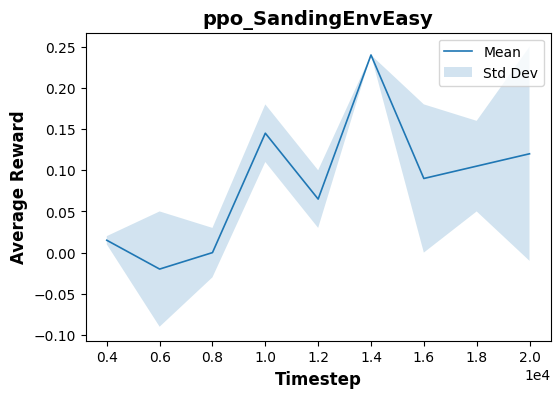

In [49]:
import utils.common_utils as cu
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' # 'ppo' or 'ddpg'

for environment in ['easy']:
    training_seeds = []
    for i in range(43, 45):
        config=setup(algo=implemented_algo, env=environment, render=False)
        config["seed"] = i
        training_seeds.append(i)
        agent=PPOAgent(config)
    # plot the statistical training curves with specific random seeds
    cu.plot_algorithm_training(agent.logging_dir, training_seeds, agent.env_name, implemented_algo)

### Testing DDPG

In [66]:
# This part is provided only for debugging

from algos.ddpg_agent import DDPGAgent

train_episodes = 10  # Limit the number of training episode for a fast test

config=setup(algo='ddpg', env='easy', train_episodes=train_episodes, render=False)

config["seed"] = 42

print("The configs of DDPG is")
print(config)
print()

# {
# 'args': namespace(cfg_path=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/cfg'), 
# algo_name='ddpg', 
# exp_name='project', 
# env_name='SandingEnvEasy', 
# run_id='sanding-env-easy', 
# max_action=1.0, 
# max_episode_steps=20, 
# train_episodes=1000, 
# test_episodes=10, 
# min_update_samples=2000, 
# testing=False, 
# model_path='default', 
# save_video=True, 
# save_logging=True, 
# save_model=True, 
# silent=False, 
# log_interval=2000, 
# run_suffix=0, 
# device='cpu', 
# env_config={'n_sanding': 1, 'n_no_sanding': 1, 'is_PD_control': True, 'radius': 10, 'render_mode': 'rgb_array'}, seed=0, agent_name='ddpg', gamma=0.99, lr='3e-4', tau=0.005, batch_size=256, buffer_size='1e6', 
# work_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg'), 
# model_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg/model'), 
# logging_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg/logging'), 
# video_train_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg/video/train'), video_test_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg/video/test')), 
# 'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<SandingEnv<SandingEnvEasy>>>>>, 
# 'eval_env': None, 
# 'action_space_dim': 2, 
# 'observation_space_dim': 6, 
# 'seed': 43}

if config["args"].algo_name == 'ppo':
    agent=PPOAgent(config)
elif config["args"].algo_name == 'ddpg':
    agent=DDPGAgent(config)
else:
    raise Exception('Please use ppo or ddpg!')

# Train the agent using the selected algorithm    
agent.train()
test(agent, 'easy', 'ddpg')


The configs of DDPG is
{'args': namespace(cfg_path=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/cfg'), algo_name='ddpg', exp_name='project', env_name='SandingEnvEasy', run_id='sanding-env-easy', max_action=1.0, max_episode_steps=20, train_episodes=10, test_episodes=10, min_update_samples=2000, testing=False, model_path='default', save_video=True, save_logging=True, save_model=True, silent=False, log_interval=2000, run_suffix=0, device='cpu', env_config={'n_sanding': 1, 'n_no_sanding': 1, 'is_PD_control': True, 'radius': 10, 'render_mode': 'rgb_array'}, seed=0, agent_name='ddpg', gamma=0.99, lr='3e-4', tau=0.005, batch_size=256, buffer_size='1e6', work_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg'), model_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Project/results/SandingEnvEasy/ddpg/model'), logging_dir=WindowsPath('c:/Users/springnuance/Desktop/Reinforcement-Learning-Pro

KeyboardInterrupt: 

steps 0        20
1      2020
2      4020
3      6020
4      8020
5     10020
6     12020
7     14020
8     16020
9     18020
10    20020
Name: total_step, dtype: int64
mean_average_return [ 1.   -0.01 -0.03 -0.11 -0.05 -0.04  0.12  0.22  0.38  0.45  0.51]
std_average_return [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


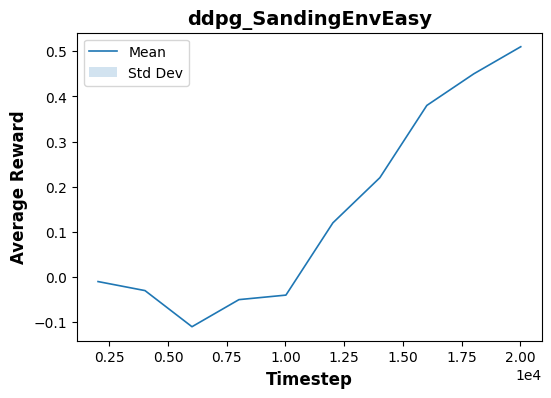

In [ ]:
implemented_algo ='ddpg' # 'ppo' or 'ddpg'
import utils.common_utils as cu
for environment in ['easy']:
    training_seeds = []
    for i in range(43, 44):
        config=setup(algo=implemented_algo, env=environment, render=False)
        config["seed"] = i
        training_seeds.append(i)
        agent=DDPGAgent(config)
    # plot the statistical training curves with specific random seeds
    cu.plot_algorithm_training(agent.logging_dir, training_seeds, agent.env_name, implemented_algo)

**If everything is fine, we start the proper training now**

### Training DDPG
#### Each cell takes about 35 minutes to finish training. In total 9 cases should take around 6 hours.

In [ ]:
# ## Code block for training and testing an agent using the implemented algorithm
# ## in the three different sanding environment versions with different difficulty levels

# # Choose either PPO or DDPG
# implemented_algo ='ddpg'  #'ppo' or 'ddpg'

# # Loop over the three difficulty levels
# for environment in ['easy', 'middle', 'difficult']:
#     training_seeds = []
    
#     # Train the algorithm with a specific random seed.
#     # In total, we train the algorithm with three random seeds [0, 1, 2].
#     for i in range(3):
#         config=setup(algo=implemented_algo, env=environment)

#         config["seed"] = i
#         training_seeds.append(i)

#         if config["args"].algo_name == 'ppo':
#             agent=PPOAgent(config)
#         elif config["args"].algo_name == 'ddpg':
#             agent=DDPGAgent(config)
#         else:
#             raise Exception('Please use ppo or ddpg!')
    
#         # Train the agent using selected algorithm    
#         agent.train()

In [30]:
implemented_algo ='ddpg' 
environment = 'easy'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 0
agent=DDPGAgent(config)
agent.train()

c:\Users\springnuance\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\utils\recorder.py:250: UserWarning: WARN: Overwriting existing videos at c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\springnuance\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_

Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4
Episode 0 Step 20 finished. Average episode return: 1.0
Episode 100 Step 2020 finished. Average episode return: 0.0
Episode 200 Step 4020 finished. Average episode return: -0.05
Episode 300 Step 6020 finished. Average episode return: 0.06
Episode 400 Step 8020 finished. Average episode return: -0.03
Episode 500 Step 10020 finished. Average episode return: 0.1
Episode 600 Step 12020 finished. Average episode return: 0.21
Episode 700 Step 14020 finished. Average episode return: 0.12
Episode 800 Step 16020 finished. Average episode return: 0.33
Episode 900 Step 18020 finished. Average episode return: 0.31
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-1000.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-1000.mp4
Episode 1000 Step 20020 finished. Average episode return: 0.23
Episode 1100 Step 22020 finished. Average episode return: 0.38
Episode 1200 Step 24020 finished. Average episode return: 0.35
Episode 1300 Step 26020 finished. Average episode return: 0.5
Episode 1400 Step 28020 finished. Average episode return: 0.4
Episode 1500 Step 30020 finished. Average episode return: 0.6
Episode 1600 Step 32020 finished. Average episode return: 0.54
Episode 1700 Step 34020 finished. Average episode return: 0.53
Episode 1800 Step 36020 finished. Average episode return: 0.54
Episode 1900 Step 38020 finished. Average episode return: 0.53
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-2000.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Re

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-2000.mp4
Episode 2000 Step 40020 finished. Average episode return: 0.57
Episode 2100 Step 42020 finished. Average episode return: 0.58
Episode 2200 Step 44020 finished. Average episode return: 0.57
Episode 2300 Step 46020 finished. Average episode return: 0.49
Episode 2400 Step 48020 finished. Average episode return: 0.6
Episode 2500 Step 50020 finished. Average episode return: 0.59
Episode 2600 Step 52020 finished. Average episode return: 0.71
Episode 2700 Step 54020 finished. Average episode return: 0.6
Episode 2800 Step 56020 finished. Average episode return: 0.54
Episode 2900 Step 58020 finished. Average episode return: 0.61
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-3000.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\R

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-3000.mp4
Episode 3000 Step 60020 finished. Average episode return: 0.68
Episode 3100 Step 62020 finished. Average episode return: 0.6
Episode 3200 Step 64020 finished. Average episode return: 0.56
Episode 3300 Step 66020 finished. Average episode return: 0.69
Episode 3400 Step 68020 finished. Average episode return: 0.64
Episode 3500 Step 70020 finished. Average episode return: 0.58
Episode 3600 Step 72020 finished. Average episode return: 0.56
Episode 3700 Step 74020 finished. Average episode return: 0.62
Episode 3800 Step 76020 finished. Average episode return: 0.6
Episode 3900 Step 78020 finished. Average episode return: 0.63
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-4000.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\R

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-4000.mp4
Episode 4000 Step 80020 finished. Average episode return: 0.62
Episode 4100 Step 82020 finished. Average episode return: 0.64
Episode 4200 Step 84020 finished. Average episode return: 0.6
Episode 4300 Step 86020 finished. Average episode return: 0.67
Episode 4400 Step 88020 finished. Average episode return: 0.67
Episode 4500 Step 90020 finished. Average episode return: 0.6
Episode 4600 Step 92020 finished. Average episode return: 0.66
Episode 4700 Step 94020 finished. Average episode return: 0.65
Episode 4800 Step 96020 finished. Average episode return: 0.72
Episode 4900 Step 98020 finished. Average episode return: 0.58
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-5000.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\R

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-5000.mp4
Episode 5000 Step 100020 finished. Average episode return: 0.66
Episode 5100 Step 102020 finished. Average episode return: 0.68
Episode 5200 Step 104020 finished. Average episode return: 0.62
Episode 5300 Step 106020 finished. Average episode return: 0.6
Episode 5400 Step 108020 finished. Average episode return: 0.64
Episode 5500 Step 110020 finished. Average episode return: 0.69
Episode 5600 Step 112020 finished. Average episode return: 0.74
Episode 5700 Step 114020 finished. Average episode return: 0.6
Episode 5800 Step 116020 finished. Average episode return: 0.69
Episode 5900 Step 118020 finished. Average episode return: 0.58
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-6000.mp4.
Moviepy - Writing video c:\Users\springnuance

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-6000.mp4
Episode 6000 Step 120020 finished. Average episode return: 0.74
Episode 6100 Step 122020 finished. Average episode return: 0.63
Episode 6200 Step 124020 finished. Average episode return: 0.67
Episode 6300 Step 126020 finished. Average episode return: 0.65
Episode 6400 Step 128020 finished. Average episode return: 0.6
Episode 6500 Step 130020 finished. Average episode return: 0.7
Episode 6600 Step 132020 finished. Average episode return: 0.66
Episode 6700 Step 134020 finished. Average episode return: 0.61
Episode 6800 Step 136020 finished. Average episode return: 0.6
Episode 6900 Step 138020 finished. Average episode return: 0.64
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-7000.mp4.
Moviepy - Writing video c:\Users\springnuance\

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-7000.mp4
Episode 7000 Step 140020 finished. Average episode return: 0.78
Episode 7100 Step 142020 finished. Average episode return: 0.65
Episode 7200 Step 144020 finished. Average episode return: 0.7
Episode 7300 Step 146020 finished. Average episode return: 0.73
Episode 7400 Step 148020 finished. Average episode return: 0.66
Episode 7500 Step 150020 finished. Average episode return: 0.64
Episode 7600 Step 152020 finished. Average episode return: 0.61
Episode 7700 Step 154020 finished. Average episode return: 0.7
Episode 7800 Step 156020 finished. Average episode return: 0.69
Episode 7900 Step 158020 finished. Average episode return: 0.66
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-8000.mp4.
Moviepy - Writing video c:\Users\springnuance

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-8000.mp4
Episode 8000 Step 160020 finished. Average episode return: 0.67
Episode 8100 Step 162020 finished. Average episode return: 0.66
Episode 8200 Step 164020 finished. Average episode return: 0.69
Episode 8300 Step 166020 finished. Average episode return: 0.75
Episode 8400 Step 168020 finished. Average episode return: 0.69
Episode 8500 Step 170020 finished. Average episode return: 0.64
Episode 8600 Step 172020 finished. Average episode return: 0.7
Episode 8700 Step 174020 finished. Average episode return: 0.59
Episode 8800 Step 176020 finished. Average episode return: 0.68
Episode 8900 Step 178020 finished. Average episode return: 0.66
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-9000.mp4.
Moviepy - Writing video c:\Users\springnuanc

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-9000.mp4
Episode 9000 Step 180020 finished. Average episode return: 0.63
Episode 9100 Step 182020 finished. Average episode return: 0.57
Episode 9200 Step 184020 finished. Average episode return: 0.58
Episode 9300 Step 186020 finished. Average episode return: 0.64
Episode 9400 Step 188020 finished. Average episode return: 0.69
Episode 9500 Step 190020 finished. Average episode return: 0.66
Episode 9600 Step 192020 finished. Average episode return: 0.72
Episode 9700 Step 194020 finished. Average episode return: 0.6
Episode 9800 Step 196020 finished. Average episode return: 0.68
Episode 9900 Step 198020 finished. Average episode return: 0.65
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-10000.mp4.
Moviepy - Writing video c:\Users\springnuan

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-10000.mp4
Episode 10000 Step 200020 finished. Average episode return: 0.64
Saved model to c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\model/model_parameters_0.pt ...
logger and seed 0
c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\logging/logs_0.csv
------ Training Finished ------
Total traning time is 34.83253176333334mins


In [86]:
implemented_algo ='ddpg' 
environment = 'easy'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 1
agent=DDPGAgent(config)
agent.train()

Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4


Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\train\project-episode-0.mp4
Episode 0 Step 20 finished. Average episode return: 1.0


KeyboardInterrupt: 

In [ ]:
implemented_algo ='ddpg' 
environment = 'easy'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 2
agent=DDPGAgent(config)
agent.train()

In [ ]:
implemented_algo ='ddpg' 
environment = 'middle'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 0
agent=DDPGAgent(config)
agent.train()

In [ ]:
implemented_algo ='ddpg' 
environment = 'middle'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 1
agent=DDPGAgent(config)
agent.train()

In [ ]:
implemented_algo ='ddpg' 
environment = 'middle'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 2
agent=DDPGAgent(config)
agent.train()

In [ ]:
implemented_algo ='ddpg' 
environment = 'difficult'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 0
agent=DDPGAgent(config)
agent.train()

In [ ]:
implemented_algo ='ddpg' 
environment = 'difficult'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 1
agent=DDPGAgent(config)
agent.train()

In [ ]:
implemented_algo ='ddpg' 
environment = 'difficult'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 2
agent=DDPGAgent(config)
agent.train()

### Training PPO
#### Each cell takes about 35 minutes to finish training. In total 9 cases should take around 6 hours.

In [88]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'easy'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 0
agent=PPOAgent(config)
agent.train()

Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4
Setting seed to 0
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4
Episode 99 Step 2000 finished. Average episode return: -0.03 (20 episode_length)
Updating the policy...
Updating finished!
Episode 199 Step 4000 finished. Average episode return: -0.01 (20 episode_length)
Updating the policy...
Updating finished!
Episode 299 Step 6000 finished. Average episode return: 0.05 (20 episode_length)
Updating the policy...
Updating finished!
Episode 399 Step 8000 finished. Average episode return: 0.01 (20 episode_length)
Updating the policy...
Updating finished!
Episode 499 Step 10000 finished. Average episode return: 0.07 (20 episode_length)
Updating the policy...
Updating finished!
Episode 599 Step 12000 finished. Average episode return: 0.02 (20 episode_length)
Updating the policy...
Updating finished!
Episode 699 Step 14000 finished. Average episode return: 0.07 (20 episode_length)
Updating the pol

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-1000.mp4
Episode 1099 Step 22000 finished. Average episode return: 0.15 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1199 Step 24000 finished. Average episode return: 0.2 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1299 Step 26000 finished. Average episode return: 0.21 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1399 Step 28000 finished. Average episode return: 0.24 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1499 Step 30000 finished. Average episode return: 0.15 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1599 Step 32000 finished. Average episode return: 0.17 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1699 Step 34000 finished. Average episode return: 0.19 (20 episode_length)
Upda

Moviepy - Done !


Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4
Episode 1799 Step 36000 finished. Average episode return: 0.26 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1899 Step 38000 finished. Average episode return: 0.22 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1999 Step 40000 finished. Average episode return: 0.08 (20 episode_length)
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-2000.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-2000.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-2000.mp4
Updating the policy...
Updating finished!
Episode 2099 Step 42000 finished. Average episode return: 0.1 (20 episode_length)
Updating the policy...
Updating finished!
Episode 2199 Step 44000 finished. Average episode return: 0.14 (20 episode_length)
Updating the policy...
Updating finished!
Episode 2299 Step 46000 finished. Average episode return: 0.12 (20 episode_length)
Updating the policy...
Updating finished!
Episode 2399 Step 48000 finished. Average episode return: 0.11 (20 episode_length)
Updating the policy...
Updating finished!
Episode 2499 Step 50000 finished. Average episode return: 0.13 (20 episode_length)
Updating the policy...
Updating finished!
Episode 2599 Step 52000 finished. Average episode return: 0.32 (20 episode_length)
Updating the policy...
Updating finished!
Episode 2699 Step 54000 finished. Average epi

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-3000.mp4
Updating the policy...
Updating finished!
Episode 3099 Step 62000 finished. Average episode return: 0.25 (20 episode_length)
Updating the policy...
Updating finished!
Episode 3199 Step 64000 finished. Average episode return: 0.18 (20 episode_length)
Updating the policy...
Updating finished!
Episode 3299 Step 66000 finished. Average episode return: 0.27 (20 episode_length)
Updating the policy...
Updating finished!
Episode 3399 Step 68000 finished. Average episode return: 0.21 (20 episode_length)
Updating the policy...
Updating finished!
Episode 3499 Step 70000 finished. Average episode return: 0.28 (20 episode_length)
Updating the policy...
Updating finished!
Episode 3599 Step 72000 finished. Average episode return: 0.29 (20 episode_length)
Updating the policy...
Updating finished!
Episode 3699 Step 74000 finished. Average ep

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-4000.mp4
Updating the policy...
Updating finished!
Episode 4099 Step 82000 finished. Average episode return: 0.25 (20 episode_length)
Updating the policy...
Updating finished!
Episode 4199 Step 84000 finished. Average episode return: 0.19 (20 episode_length)
Updating the policy...
Updating finished!
Episode 4299 Step 86000 finished. Average episode return: 0.26 (20 episode_length)
Updating the policy...
Updating finished!
Episode 4399 Step 88000 finished. Average episode return: 0.18 (20 episode_length)
Updating the policy...


In [83]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'easy'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 1
agent=PPOAgent(config)
agent.train()

Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4



Moviepy - Done !


Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4
Setting seed to 1
Moviepy - Building video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4.
Moviepy - Writing video c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-0.mp4
Episode 99 Step 2000 finished. Average episode return: 0.02 (20 episode_length)
Updating the policy...
Updating finished!
Episode 199 Step 4000 finished. Average episode return: 0.0 (20 episode_length)
Updating the policy...
Updating finished!
Episode 299 Step 6000 finished. Average episode return: -0.01 (20 episode_length)
Updating the policy...
Updating finished!
Episode 399 Step 8000 finished. Average episode return: 0.05 (20 episode_length)
Updating the policy...
Updating finished!
Episode 499 Step 10000 finished. Average episode return: -0.03 (20 episode_length)
Updating the policy...
Updating finished!
Episode 599 Step 12000 finished. Average episode return: 0.0 (20 episode_length)
Updating the policy...
Updating finished!
Episode 699 Step 14000 finished. Average episode return: 0.01 (20 episode_length)
Updating the polic

Moviepy - Done !
Moviepy - video ready c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\train\project-episode-1000.mp4
Episode 1099 Step 22000 finished. Average episode return: -0.02 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1199 Step 24000 finished. Average episode return: -0.02 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1299 Step 26000 finished. Average episode return: 0.02 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1399 Step 28000 finished. Average episode return: 0.02 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1499 Step 30000 finished. Average episode return: 0.04 (20 episode_length)
Updating the policy...
Updating finished!
Episode 1599 Step 32000 finished. Average episode return: -0.01 (20 episode_length)
Updating the policy...
Updating finished!


KeyboardInterrupt: 

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'easy'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 2
agent=PPOAgent(config)
agent.train()

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'middle'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 0
agent=PPOAgent(config)
agent.train()

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'middle'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 1
agent=PPOAgent(config)
agent.train()

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'middle'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 2
agent=PPOAgent(config)
agent.train()

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'difficult'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 0
agent=PPOAgent(config)
agent.train()

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'difficult'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 1
agent=PPOAgent(config)
agent.train()

In [ ]:
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'difficult'

config=setup(algo=implemented_algo, env=environment)
config["seed"] = 2
agent=PPOAgent(config)
agent.train()

## Task 1.2: Evaluate the Performance of Each Agent

For each environment, the algorithm has been trained using three different random seeds, resulting in the generation of three distinct models for each algorithm. Our next step is to assess the performance of each model.

- Execute the code below and document the performance of each model:
  - Report the mean and standard deviation of the performance across the three random seeds.
 
- Use the provided report format below, and input the values based on the results of your experiments.


In [ ]:
# ## Code block for training and testing an agent using the implemented algorithm
# ## in the three different Tasks with different difficulty levels
# import warnings
# warnings.filterwarnings('ignore')

# # NOTE: Uncomment the algorithm you implemented
# implemented_algo ='ddpg' #'ddpg' or 'ppo'

# # Loop over the three difficulty levels
# for environment in ['easy', 'middle', 'difficult']:

#     training_seeds = []
    
#     # for each algorithm, we will test the agent trained with specific random seed
#     for i in range(3):
#         config=setup(algo=implemented_algo, env=environment, render=False)

#         config["seed"] = i
#         training_seeds.append(i)

#         if config["args"].algo_name == 'ppo':
#             agent=PPOAgent(config)
#         elif config["args"].algo_name == 'ddpg':
#             agent=DDPGAgent(config)
#         else:
#             raise Exception('Please use ppo or ddpg!')
        
#         print('\n\n\nnow start testing for environment',environment,' agent:',implemented_algo,' seed:',i)
#         # Test the agent in the selected environment
#         test(agent, environment, implemented_algo)

In [54]:
from algos.ppo_agent import PPOAgent

implemented_algo ='ppo'
environment = 'easy'

config=setup(algo=implemented_algo, env=environment, render=False)
config["seed"] = 0
agent=PPOAgent(config)
print('\n\n\nnow start testing for environment',environment,' agent:',implemented_algo,' seed:', 0)

test(agent, environment, implemented_algo)

Setting seed to 0



now start testing for environment easy  agent: ppo  seed: 0
Testing...
Saved GIF to c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ppo\video\test\_seed_None_ep_0.gif
Average test reward over 10 episodes: 0.3,+- 0.45825756949558394;         Average episode length: 20.0


In [33]:
implemented_algo ='ddpg' 
environment = 'easy'


config=setup(algo=implemented_algo, env=environment, render=False)
config["seed"] = 0
agent=DDPGAgent(config)
print('\n\n\nnow start testing for environment',environment,' agent:',implemented_algo,' seed:', 0)

test(agent, environment, implemented_algo)




now start testing for environment easy  agent: ddpg  seed: 0
model loaded: c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\model/model_parameters_0.pt
Testing...
Saved GIF to c:\Users\springnuance\Desktop\Reinforcement-Learning-Project\results\SandingEnvEasy\ddpg\video\test\_seed_0_ep_0.gif
Average test reward over 10 episodes: 0.4,+- 0.48989794855663565;         Average episode length: 20.0


**Write your answers here**:

- PPO_Easy_environment:
    - mean:
    - standard deviation:
<br>
- PPO_Middle_environment:
    - mean:
    - standard deviation:
<br>    
- PPO_Difficult_environment:
    - mean:
    - standard deviation:
    
 or 
 
 
- DDPG_Easy_environment:
    - mean:
    - standard deviation:
<br>
- DDPG_Middle_environment:
    - mean:
    - standard deviation:
<br>
- DDPG_Difficult_environment:
    - mean:
    - standard deviation:

**Note:** 
    
    - **Your algorithm should demonstrate performance comparable to the baselines, otherwise the answer will be considered as invalid.** 
    - **We will also run the code to verify the performance.**

#### PPO Baseline Performance:
- PPO (Easy Environment): mean: 0.63, standard deviation: 0.18
- PPO (Middle Environment): mean: 0.75, standard deviation: 0.32
- PPO (Difficult Environment): mean: 0.83, standard deviation: 0.41

#### DDPG Baseline Performance:
- DDPG (Easy Environment): mean: 0.73, standard deviation: 0.28
- DDPG (Middle Environment): mean: 0.81, standard deviation: 0.18
- DDPG (Difficult Environment): mean: 0.76, standard deviation: 0.25

</span>



    

If you are curious about visualizing policy behaviours, you can run the following code


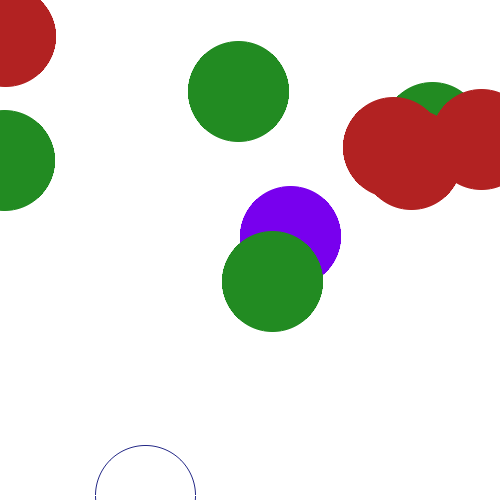

In [8]:
            
# The example of visualizing the saved test GIFs
from IPython.display import display, Image

# Display the GIF in Jupyter
display(Image(filename="imgs/difficult_env.gif"))  # Change the file path to display yours


## Task 1.3: Plot the algorithm's performance in each environment

If all above code runs successfully, now we want to make a plot of the algorithm's training performance. You can run the code below to make plots. The training performance will look similar to this:

<p align="center">
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/ppo_statistical_SandingEnvEasy.png" alt="PPO Easy Environment" width="240"/>
    <figcaption>PPO Easy</figcaption>
  </figure>
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/ppo_statistical_SandingEnvMiddle.png" alt="PPO Middle Environment" width="240"/>
    <figcaption>PPO Middle</figcaption>
  </figure>
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/ppo_statistical_SandingEnvDifficult.png" alt="PPO Difficult Environment" width="240"/>
    <figcaption>PPO Difficult</figcaption>
  </figure>
</p>
<p align="center">
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/ddpg_statistical_SandingEnvEasy.png" alt="DDPG Easy Environment" width="240"/>
    <figcaption>DDPG Easy</figcaption>
  </figure>
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/ddpg_statistical_SandingEnvMiddle.png" alt="DDPG Middle Environment" width="240"/>
    <figcaption>DDPG Middle</figcaption>
  </figure>
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/ddpg_statistical_SandingEnvDifficult.png" alt="DDPG Difficult Environment" width="240"/>
    <figcaption>DDPG Difficult</figcaption>
  </figure>
</p>

**Note**: You do not need to make the plots look exactly the same as shown above.  The following code generates 3 figures (1 algorithm x 3 environments). Please comment below the algorithm you did not implement.

### Paths:
Your plot should be plotted in the following paths if the code runs successfully:

- **PPO Easy**: 
  - `results/SandingEnvMiddle/PPO/logging/figure_statistical_SandingEnvEasy.pdf`
- **PPO Middle**: 
  - `results/SandingEnvMiddle/PPO/logging/figure_statistical_SandingEnvMiddle.pdf`
- **PPO Difficult**: 
  - `results/SandingEnvMiddle/PPO/logging/figure_statistical_SandingEnvDifficult.pdf`
 
 or
 
- **DDPG Easy**: 
  - `results/SandingEnvMiddle/DDPG/logging/figure_statistical_SandingEnvEasy.pdf`
- **DDPG Middle**: 
  - `results/SandingEnvMiddle/DDPG/logging/figure_statistical_SandingEnvMiddle.pdf`
- **DDPG Difficult**: 
  - `results/SandingEnvMiddle/DDPG/logging/figure_statistical_SandingEnvDifficult.pdf`


In [ ]:
# ## Run the following code to plot PPO or DDPG's training performances
# import warnings
# warnings.filterwarnings('ignore')

# # Uncomment the algorithm you chose 
# implemented_algo ='ddpg' # 'ppo' or 'ddpg'


# # Loop over the three difficulty levels
# for environment in ['easy', 'middle', 'difficult']:

#     training_seeds = []
#     for i in range(3):
#         config=setup(algo=implemented_algo, env=environment, render=False)

#         config["seed"] = i
#         training_seeds.append(i)


#         if config["args"].algo_name == 'ppo':
#             agent=PPOAgent(config)
#         elif config["args"].algo_name == 'ddpg':
#             agent=DDPGAgent(config)
#         else:
#             raise Exception('Please use ppo or ddpg!')

#     # plot the statistical training curves with specific random seeds
#     cu.plot_algorithm_training(agent.logging_dir, training_seeds, agent.env_name, implemented_algo)


Setting seed to 0


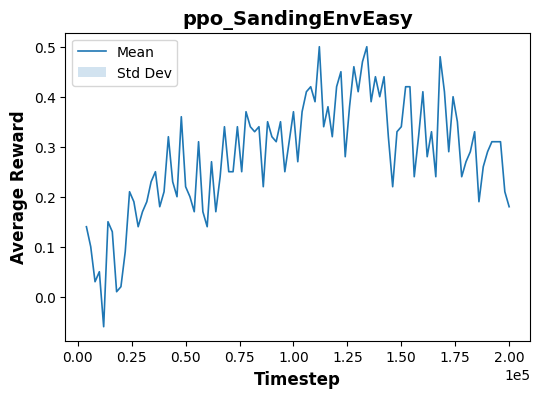

In [55]:
implemented_algo ='ppo' # 'ppo' or 'ddpg'

for environment in ['easy']:
    training_seeds = []
    for i in range(0, 1):
        config=setup(algo=implemented_algo, env=environment, render=False)
        config["seed"] = i
        training_seeds.append(i)
        agent=PPOAgent(config)
    # plot the statistical training curves with specific random seeds
    cu.plot_algorithm_training(agent.logging_dir, training_seeds, agent.env_name, implemented_algo)

Setting seed to 0


(0       2000
 1       4000
 2       6000
 3       8000
 4      10000
        ...  
 95    192000
 96    194000
 97    196000
 98    198000
 99    200000
 Name: total_step, Length: 100, dtype: int64,
 array([ 0.04,  0.14,  0.1 ,  0.03,  0.05, -0.06,  0.15,  0.13,  0.01,
         0.02,  0.09,  0.21,  0.19,  0.14,  0.17,  0.19,  0.23,  0.25,
         0.18,  0.21,  0.32,  0.23,  0.2 ,  0.36,  0.22,  0.2 ,  0.17,
         0.31,  0.17,  0.14,  0.27,  0.17,  0.24,  0.34,  0.25,  0.25,
         0.34,  0.25,  0.37,  0.34,  0.33,  0.34,  0.22,  0.35,  0.32,
         0.31,  0.35,  0.25,  0.31,  0.37,  0.27,  0.37,  0.41,  0.42,
         0.39,  0.5 ,  0.34,  0.38,  0.32,  0.42,  0.45,  0.28,  0.38,
         0.46,  0.41,  0.47,  0.5 ,  0.39,  0.44,  0.4 ,  0.44,  0.32,
         0.22,  0.33,  0.34,  0.42,  0.42,  0.24,  0.32,  0.41,  0.28,
         0.33,  0.24,  0.48,  0.41,  0.29,  0.4 ,  0.35,  0.24,  0.27,
         0.29,  0.33,  0.19,  0.26,  0.29,  0.31,  0.31,  0.31,  0.21,
         0.18]),
 a

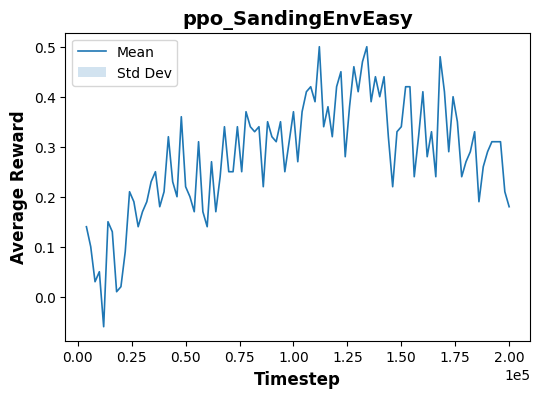

In [39]:
## Run the following code to plot PPO or DDPG's training performances
import warnings
warnings.filterwarnings('ignore')
from algos.ppo_agent import PPOAgent
implemented_algo ='ppo' 
environment = 'easy'
config=setup(algo=implemented_algo, env=environment, render=False)
config["seed"] = 0
agent=PPOAgent(config)
cu.plot_algorithm_training(agent.logging_dir, [0], agent.env_name, implemented_algo)

DOUBLE CLICK HERE TO EDIT, RUN the above code to make training plots for each algorithm

<a id='T2'></a>
<div class="alert alert-warning">
    <h3><b>Student Task 2</b> (40 points)</h3>
    Your objective in this task is to enhance the performance of the DDPG/PPO algorithms, taking inspiration from the suggestions provided in Section 5.II. Carefully read the extension guidelines outlined in Section 5.II, and proceed to modify either 'ddpg_extension.py' or 'ppo_extension.py' located in the 'algos' folder. 

    1. You must elevate the base algorithm's performance to ensure the agent's success in the moderate difficulty environment (environment = 'middle'). 
    
    2. Please document your results here, including the training plots and test performance.
    
    3. Adhere to the given structure to facilitate testing with 'setup' and 'test'  function.
    
    4. If you choose PPO, implement 2 extensions. If you opt for DDPG, implement at least 1 extension.
    
    5. In cases where multiple extensions are implemented, conduct a thorough analysis to discern the performance variations between the different extensions.
</div>


## Task 2.1: Enhance Your Chosen Algorithm

### a) Overview
Improve the performance of your selected reinforcement learning algorithm. Ensure that your implementations are properly documented and organized for clarity.

### b) Implementation Details
- **Algorithm Improvements**: Enhance your chosen algorithm.
  - For PPO, implement **at least two extensions**.
  - For DDPG, implement **at least one extension**.
  - Ensure that the performance is noticeably improved.
  - Place your implementations in the appropriate file:
    - 'algo/ddpg_extension.py' for DDPG
    - 'algo/ppo_extension.py' for PPO

### c) Training
- **Random Seeds**: Train your algorithm using three distinct random seeds [0,1,2] to ensure robustness and repeatability.

### d) Evaluation
- **Environment**: Evaluate your algorithm exclusively in the **middle-level difficulty environment** to focus your improvements.

### e) Code Compatibility
- Ensure that your code is **fully compatible** with all existing functions in other files, maintaining the integrity of the overall project structure.

---



**Train**: After implementing the improvement extensions, run the following code to train your agents.

In [10]:
# Implement your improved algorithm either in algo/ddpg_extension.py or algo/ppo_extension.py
from algos.ddpg_extension import DDPGExtension
from algos.ppo_extension import PPOExtension

implemented_algo = ''# choose 'ppo_extension' or 'ddpg_extension'
environment = 'middle'

training_seeds = []
for i in range(3):
    config=setup(algo=implemented_algo, env=environment)

    config["seed"] = i
    training_seeds.append(i)


    if config["args"].algo_name == 'ppo_extension':
        agent=PPOExtension(config)
    elif config["args"].algo_name == 'ddpg_extension':
        agent=DDPGExtension(config)
    else:
        raise Exception('Please use ppo or ddpg!')

    # Train the agent using selected algorithm    
    agent.train()


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\springnuance\\Desktop\\Reinforcement-Learning-Project\\cfg\\algo\\.yaml'

**Test**: After training, run the following code to test your agents.

In [ ]:
training_seeds = []
for i in range(3):
    config=setup(algo=implemented_algo, env=environment)

    config["seed"] = i
    training_seeds.append(i)


    if config["args"].algo_name == 'ppo_extension':
        agent=PPOExtension(config)
    elif config["args"].algo_name == 'ddpg_extension':
        agent=DDPGExtension(config)
    else:
        raise Exception('Please use ppo or ddpg!')

    # Test the agent in the selected environment
    test(agent, environment, implemented_algo)


**Write your answers here**:


   
- PPO_extension_Middle_environment:
    - mean:
    - standard deviation:

 or 
 
 
- DDPG_extension_Middle_environment:
    - mean:
    - standard deviation:
 
 ---

## Task 2.2: Plot improved algorithm performance 

### a) Display the plots:
Display the training performance of your improved algorithm, similarly as in task 1.3

### b) Paths:
Your plot should be plotted in the following paths if the code runs successfully:

- **improved Middle**: 
  - `results/SandingEnvMiddle/ppo_extension(or ddpg_extension)/logging/figure_statistical_SandingEnvMiddle.pdf`



In [ ]:
## Run the following code to plot PPO or DDPG's training performances
import warnings
warnings.filterwarnings('ignore')

# Uncomment the algorithm you chose 
implemented_algo =# 'ppo_extension' or 'ddpg_extension'
environment = 'middle'

# Loop over the three difficulty levels

training_seeds = [0,1,2]

config=setup(algo=implemented_algo, env=environment, render=False)

config["seed"] = 0

agent=# DDPGExtension(config) or PPOExtension(config)

# plot the statistical training curves with specific random seeds
cu.plot_algorithm_training(agent.logging_dir, training_seeds, agent.env_name, implemented_algo)


## Task 2.3: Comparison of Improved and Original Algorithm Performance

### a) Display the Plots
Display the training performance of both the improved and the original algorithms.

We aim to compare the training performances of the original and improved algorithms. To achieve this, we will generate the following plots, which will highlight the sample efficiency and the agent's performance throughout the training process. Below are some figures comparing the performances of DDPG and PPO:

<p align="center">
  <figure style="display: inline-block; text-align: center; margin: 10px;">
    <img src="imgs/middle_compare_ddpg_ppo.png" alt="PPO Middle Environment" width="540"/>
    <figcaption>PPO vs DDPG (Middle environment)</figcaption>
  </figure>
  
</p>

**Note**: The display does not need to exactly match the figures shown above. However, the code should generate a figure to compare the original algorithm with the improved algorithm.

### b) Paths
If the code runs successfully, your plot should be saved to the following paths:

- **Original vs Improved (Middle Environment)**: 
  - `results/SandingEnvMiddle/compare_ddpg_ddpg_extension.pdf`
  - or 
  - `results/SandingEnvMiddle/compare_ppo_ppo_extension.pdf`


In [ ]:
## Run the following code to draw the comparison plots of PPO and DDPG's training performances
import warnings
warnings.filterwarnings('ignore')

environment = 'middle'

orgin_alo_name = # 'ddpg' or 'ppo'
improved_alo_name = # 'ddpg_extension' or 'ppo_extension'

config=setup(algo=orgin_alo_name, env=environment, render=False)
origin_agent = # DDPGAgent(config) or PPOAgent(config)

config=setup(algo=improved_alo_name, env=environment, render=False)
improved_agent = # DDPGExtension(config) or PPOExtension(config)

# make the comparison plot
cu.compare_algorithm_training(origin_agent, improved_agent, seeds=[0,1,2])

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1</b> (30 points) </h3> 
    Explain how you extended PPO/DDPG and why in a maximum of 200 words. In addition, explain briefly in which parts of the source code the changes are (refer to file name and function names or lines of code).
</div>

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE

<a id='T3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 3</b> (+20 points) </h3>
    This task give bonus points to the project works that get highest performance in the difficult environment. At the end of the course, we will use everyone's improved agent (please submit your pretrained weights) to run the competition on the most difficult sanding environment. Competitive grading: all projects are evaluated in the difficult environment for performance and put into ranking order. Top 10% of submitted projects get bonus points. Best performing project (100% ranked) gets 20 bonus points, 95% ranked gets 10 bonus points, 90% or lower ranked get 0 bonus points.
</div>

## Task 3.1: Evaluate Your Improved Algorithm with difficult environment


### a) Training
- **Random Seeds**: Train your algorithm using three distinct random seeds [0,1,2] to ensure robustness and repeatability.

### b) Evaluation
- **Environment**: Evaluate your algorithm exclusively in the **difficult-level difficulty environment** to focus your improvements.

### c) Code Compatibility
- Ensure that your code is **fully compatible** with all existing functions in other files, maintaining the integrity of the overall project structure.

---



In [ ]:

from algos.ddpg_agent import DDPGAgent
from algos.ppo_agent import PPOAgent
from algos.ddpg_extension import DDPGExtension
from algos.ppo_extension import PPOExtension
# implement your improved algorithm either in algo/ddpg_extension.py or algo/ppo_extension.py

implemented_algo = ''# choose 'ppo_extension' or 'ddpg_extension'
environment = 'difficult'


training_seeds = []
for i in range(3):
    config=setup(algo=implemented_algo, env=environment)

    config["seed"] = i
    training_seeds.append(i)


    if config["args"].algo_name == 'ppo':
        agent=PPOAgent(config)
    elif config["args"].algo_name == 'ddpg':
        agent=DDPGAgent(config)
    elif config["args"].algo_name == 'ppo_extension':
        agent=PPOExtension(config)
    elif config["args"].algo_name == 'ddpg_extension':
        agent=DDPGExtension(config)
    else:
        raise Exception('Please use ppo or ddpg!')

    # Train the agent using selected algorithm    
    agent.train()

  

**Test**: After training, run the following code to test your agents.

In [ ]:
training_seeds = []
for i in range(3):
    config=setup(algo=implemented_algo, env=environment)

    config["seed"] = i
    training_seeds.append(i)


    if config["args"].algo_name == 'ppo_extension':
        agent=PPOExtension(config)
    elif config["args"].algo_name == 'ddpg_extension':
        agent=DDPGExtension(config)
    else:
        raise Exception('Please use ppo or ddpg!')

    # Test the agent in the selected environment
    test(agent, environment, implemented_algo)


**Write your answers here**:


   
- PPO_extension_Difficult_environment:
    - mean:
    - standard deviation:

 or 
 
 
- DDPG_extension_Difficult_environment:
    - mean:
    - standard deviation:
 
 ---

## Task 3.2: Plot the Improved Algorithm's Performance 

#### Display the Plots
Display the training performance of your improved algorithm, similar to what was done in Task 2.2.

#### Paths
If the code runs successfully, your plot should be saved to the following paths:

- **Improved Difficult**: 
  - `results/SandingEnvDifficult/ppo_extension/logging/figure_statistical_SandingEnvDifficult.pdf`
  
  or
  
  - `results/SandingEnvDifficult/ddpg_extension/logging/figure_statistical_SandingEnvDifficult.pdf`


In [ ]:
## Run the following code to plot PPO or DDPG's training performances
import warnings
warnings.filterwarnings('ignore')

# Uncomment the algorithm you chose 
implemented_algo =# 'ppo_extension' or 'ddpg_extension'
environment = 'difficult'

# Loop over the three difficulty levels

training_seeds = [0,1,2]

config=setup(algo=implemented_algo, env=environment, render=False)

config["seed"] = 0

agent=# DDPGExtension(config) or PPOExtension(config)

# plot the statistical training curves with specific random seeds
cu.plot_algorithm_training(agent.logging_dir, training_seeds, agent.env_name, implemented_algo)


## Task 3.3: Plot improved algorithm's and original's comparison performance

### Display the plots:
Display the training performance of your improvement algorithm, similarly as in task 2.3

### Paths:
Your plot should be plotted in the following paths if the code runs successfully:

- **Original vs Improved (difficult environment)**: 
  - `results/SandingEnvDifficult/compare_ddpg_ddpg_extension.pdf`
  - or 
  - `results/SandingEnvDifficult/compare_ppo_ppo_extension.pdf`
  

In [ ]:
## Run the following code to draw the comparison plots of PPO and DDPG's training performances
import warnings
warnings.filterwarnings('ignore')

environment = 'difficult'

orgin_alo_name = # 'ddpg' or 'ppo'
improved_alo_name = # 'ddpg_extension' or 'ppo_extension'

config=setup(algo=orgin_alo_name, env=environment, render=False)
origin_agent = # DDPGAgent(config) or PPOAgent(config)

config=setup(algo=improved_alo_name, env=environment, render=False)
improved_agent = # DDPGExtension(config) or PPOExtension(config)

# make the comparison plot
cu.compare_algorithm_training(origin_agent, improved_agent, seeds=[0,1,2])